In [588]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [589]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [590]:
from mkl_fft import fftn, ifftn
import cupy as cp
import cupyx.scipy.fft as cufft
import scipy.fft
import cupyx.scipy.ndimage as cuimage

In [591]:
# Create the job
job = Job('/mnt/md0/runs','AH007_2022-03-28_2-4-5', create=False, overwrite=False, verbosity = 10)
tifs, si_params, exp_str = flu.find_exp(job.params['subjects_dir'], job.params['subject'],
                                        job.params['date'], job.params['expnum'])

exp_dir = flu.find_expt_file((job.params['subject'], job.params['date'], job.params['expnum'][0]),
                         'root', dirs=[job.params['subjects_dir']])
offset_files = job.get_registered_files('registered_data', 'offset')

   Found and loaded params from /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/params.npy
SI ROI pix count in x is 182, which is impossible, setting it to 145


   Saved a copy of params at /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/summary/summary.npy
Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00027.tif
Loading /mnt/a2/AH007/2022-03-28/5/AH007_ROI3p33um_NOSCREEN_-400um_00001_00016.tif
Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00014.tif
Loaded 3 files, total 20.45 GB
   Loaded movie with 300 frames and shape 30, 1202, 1015
         Enforcing positivity in mean image


/home/ali/packages/s2p-lbm/suite3d/utils.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure to /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/summary/crosstalk_plots
saved
Close figure


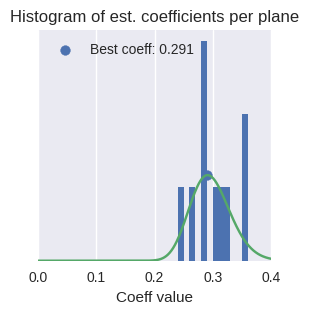

   Subtracting with estimated coefficient 0.291
          Subtracting plane 0 from 15
           Corresponds to index 0 from 15
          Subtracting plane 1 from 16
           Corresponds to index 1 from 16
          Subtracting plane 2 from 17
           Corresponds to index 2 from 17
          Subtracting plane 3 from 18
           Corresponds to index 3 from 18
          Subtracting plane 4 from 19
           Corresponds to index 4 from 19
          Subtracting plane 5 from 20
           Corresponds to index 5 from 20
          Subtracting plane 6 from 21
           Corresponds to index 6 from 21
          Subtracting plane 7 from 22
           Corresponds to index 7 from 22
          Subtracting plane 8 from 23
           Corresponds to index 8 from 23
          Subtracting plane 9 from 24
           Corresponds to index 9 from 24
          Subtracting plane 10 from 25
           Corresponds to index 10 from 25
          Subtracting plane 11 from 26
           Corresponds to index

/home/ali/packages/s2p-lbm/suite2p/suite2p/registration/register.py:89: RuntimeWarning: invalid value encountered in matmul
  cc = np.matmul(frames, frames.T)


        Computed reference for plane 0
        Computed reference for plane 1
        Computed reference for plane 2
        Computed reference for plane 3
        Computed reference for plane 4
        Computed reference for plane 5
        Computed reference for plane 6


In [ ]:
job.run_init_pass()

In [594]:
summary = job.load_summary()
min_pix_vals = summary['min_pix_vals']
crosstalk_coeff = summary['crosstalk_coeff']
refs_and_masks = summary['refs_and_masks']
all_ops = summary['all_ops']

In [595]:
summary.keys()

dict_keys(['ref_img_3d', 'ref_img_3d_unaligned', 'raw_img', 'img', 'crosstalk_coeff', 'plane_shifts', 'refs_and_masks', 'all_ops', 'min_pix_vals', 'fuse_shifts', 'fuse_ccs'])

In [602]:
raw_img = summary['raw_img']

In [22]:
__, xs = lbmio.load_and_stitch_full_tif_mp(job.tifs[0], channels=n.arange(1), get_roi_start_pix=True)
xs = n.sort(xs)

In [434]:
from scipy import ndimage

In [435]:
nz, ny, nx = raw_img.shape
n_stitch = len(xs)-1

In [537]:
from suite3d import init_pass

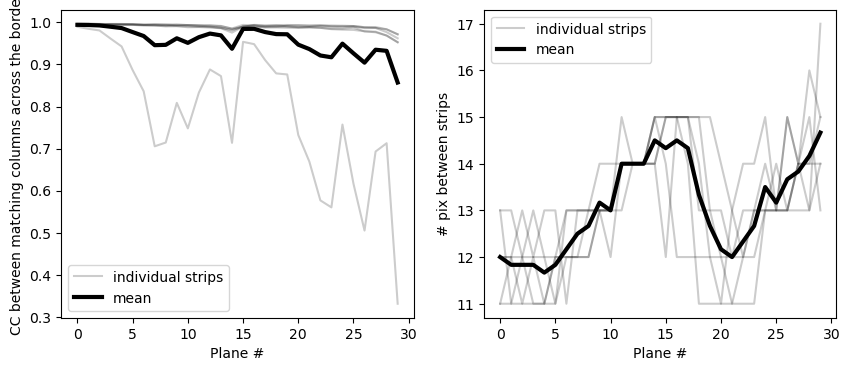

In [587]:
best_shifts, ccm = utils.get_fusing_shifts(raw_img, xs)

In [599]:
best_shifts.mean()

13.077777777777778

In [601]:
job.params['n_proc_corr']

32

In [287]:
crosses = []
for dx in dxs:
    lx = lstrip[:,-dx:]
    rx = rstrip[:, :dx]

    lrx = (lx * rx).sum(axis=-1)
    norm = n.linalg.norm(lx,axis=1) * n.linalg.norm(rx,axis=1)

    cross = lrx / norm
    crosses.append(cross)
crosses = n.array(crosses)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f1fff7c4f40>)

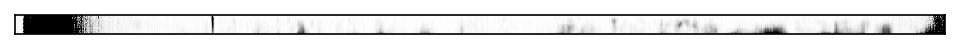

In [268]:
tfu.show_tif(crosses, vminmax=(0.9,1))

In [269]:
argmaxs = crosses.argmax(axis=0)

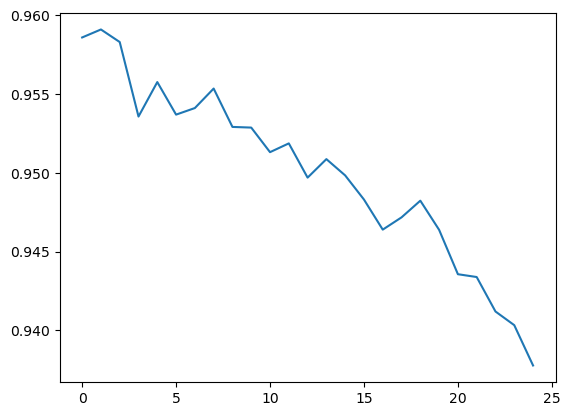

In [276]:
plt.plot(crosses.mean(axis=-1))

In [275]:
crosses.shape

(25, 1202)

In [270]:
maxs = crosses.max(axis=0)

(array([856., 173., 101.,  17.,  12.,  20.,   6.,  10.,   3.,   4.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

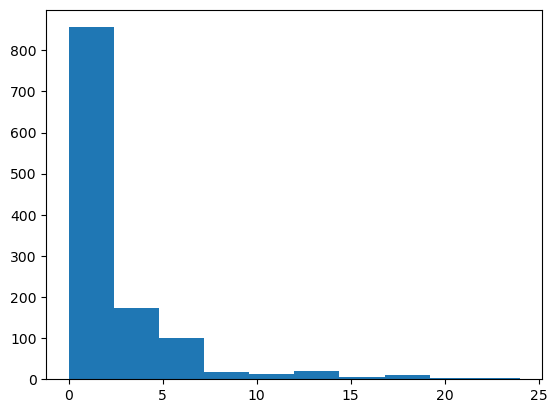

In [271]:
plt.hist(argmaxs)

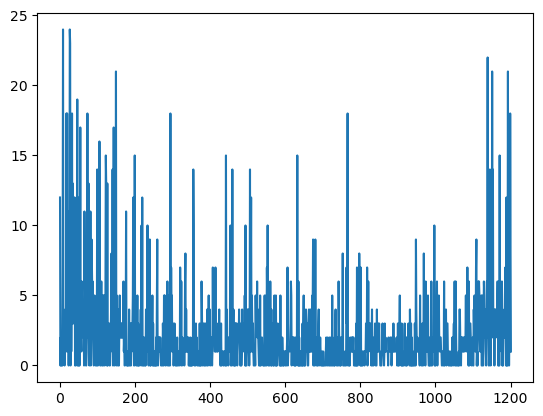

In [272]:
plt.plot(argmaxs)

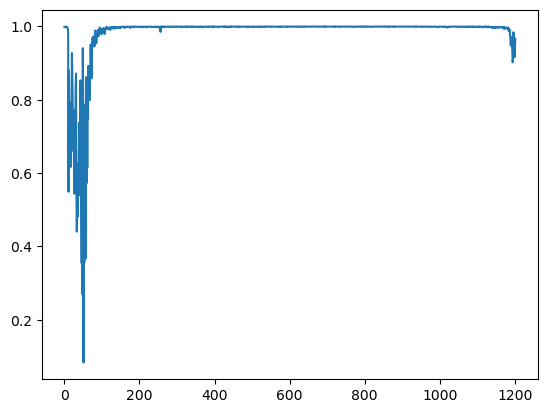

In [273]:
plt.plot(maxs)


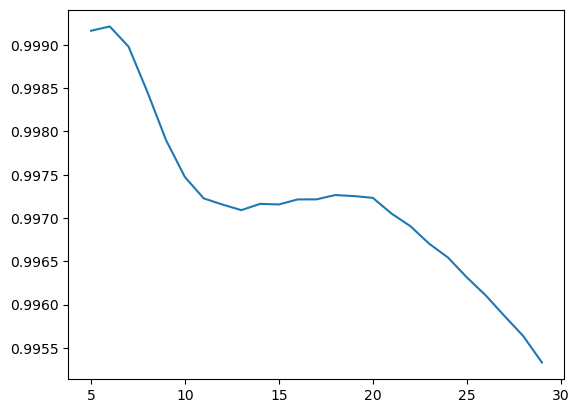

In [274]:
plt.plot(dxs, crosses[:,600:700].mean(axis=1))

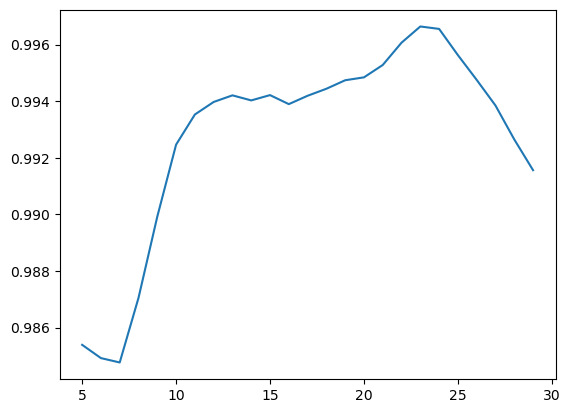

In [234]:
plt.plot(dxs, crosses[:,600:610].mean(axis=1))

In [155]:
crosses.shape

(25, 1202)

In [ ]:
lx**2.sum(a)

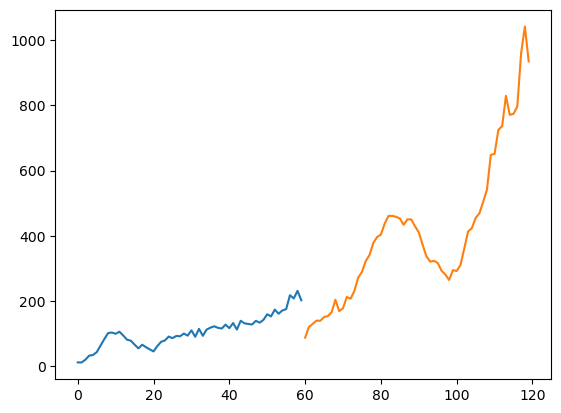

In [114]:
yidx = 900
plt.plot(n.arange(n_strip), lstrip[yidx])
plt.plot(n.arange(n_strip) + n_strip, rstrip[yidx])

In [115]:
import mkl_fft as fft

In [116]:
lstrip_f = fft.fft(lstrip,axis=1)
rstrip_f = fft.fft(rstrip,axis=1)

In [117]:
cc = fft.ifft(lstrip_f * rstrip_f,axis=1)

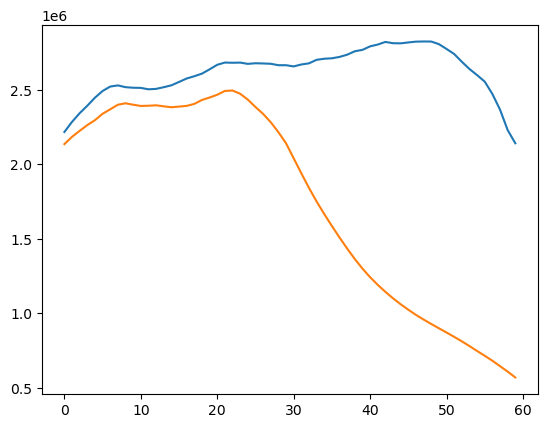

In [123]:
plt.plot(cc.real[900])
plt.plot(n.convolve(lstrip[900,], rstrip[900,], mode='same')[::-1])

In [31]:
raw_img.shape

(30, 1202, 1015)

In [28]:
xs.shape

(7,)

In [7]:
mov_raw = lbmio.load_and_stitch_tifs(job.tifs[:1], planes = n.arange(cz[0],cz[1]))[:,:,cy[0]:cy[1], cx[0]:cx[1]]
mov_raw = mov_raw[:,ct[0]:ct[1]]

Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif
Loaded 1 files, total 1.48 GB


In [123]:
%%time

CPU times: user 52.4 ms, sys: 80.6 ms, total: 133 ms
Wall time: 133 ms


In [8]:
from suite3d import iter_step

In [124]:
%%time
mov_pos = mov_raw - min_pix_vals.reshape(len(min_pix_vals), 1, 1, 1)[cz[0]:cz[1],].astype(mov_raw.dtype)
shmem_mov,shmem_mov_params, mov = utils.create_shmem_from_arr(mov_pos, copy=True)
__ = iter_step.subtract_crosstalk(shmem_mov_params, crosstalk_coeff, planes = n.arange(*cz))
all_offsets = iter_step.register_mov(mov,refs_and_masks, all_ops)
mov_out_cpu = mov.copy()
shmem_mov.close()
shmem_mov.unlink()

Subtracting plane 1 from 16
Subtracting plane 2 from 17
Subtracting plane 3 from 18
Subtracting plane 4 from 19
Subtracting plane 5 from 20
Subtracting plane 6 from 21
Subtracting plane 7 from 22
Subtracting plane 8 from 23
Subtracting plane 9 from 24
Registering plane 0
Registering plane 1
Registering plane 2
Registering plane 3
Registering plane 4
Registering plane 5
Registering plane 6
Registering plane 7
Registering plane 8
Registering plane 9
Registering plane 10
Registering plane 11
Registering plane 12
Registering plane 13
Registering plane 14
Registering plane 15
Registering plane 16
Registering plane 17
Registering plane 18
Registering plane 19
Registering plane 20
Registering plane 21
Registering plane 22
Registering plane 23
Registering plane 24
CPU times: user 2min 48s, sys: 4min 57s, total: 7min 46s
Wall time: 11.2 s


In [125]:
xmaxs_rr_cpu = n.stack(all_offsets['xms'],axis=0)
ymaxs_rr_cpu = n.stack(all_offsets['yms'],axis=0)
xmaxs_nr_cpu = n.stack(all_offsets['xm1s'],axis=1)
ymaxs_nr_cpu = n.stack(all_offsets['ym1s'],axis=1)

In [13]:
%%time
mask_mul, mask_offset, ref_2ds = n.stack([r[:3] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
mask_mul_nr, mask_offset_nr, ref_nr = n.stack([r[3:] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
rmins = n.array([op['rmin'] for op in all_ops])
rmaxs = n.array([op['rmax'] for op in all_ops])

CPU times: user 617 ms, sys: 776 ms, total: 1.39 s
Wall time: 1.39 s


In [14]:
from suite3d import register_gpu as rgpu 
from suite2p.registration import nonrigid as s2pnr
from suite2p.registration import rigid as s2prr

In [113]:
ops = all_ops[0]
snr_thresh = ops['snr_thresh']
NRsm = ops['NRsm'].astype(n.float32)
yblocks, xblocks = ops['yblock'], ops['xblock']
nblocks = ops['nblocks']
max_shift_nr = 5
max_shift_rr = 60
subpixel = 10
n_smooth_iters = 2
npad = 3

In [114]:
mempool = cp.get_default_memory_pool()

In [126]:

mov_pos = mov_raw - min_pix_vals.reshape(len(min_pix_vals), 1, 1, 1)[cz[0]:cz[1],].astype(mov_raw.dtype)

In [127]:
min_pix_vals.dtype

dtype('int64')

In [129]:
mov_pos.shape

(25, 10, 1202, 1015)

In [130]:
min_pix_vals.shape

(30,)

In [128]:
mov_raw.dtype

dtype('int16')

In [132]:
%%time
mov_shifted, ymaxs_rr, xmaxs_rr = rgpu.rigid_2d_reg_gpu(mov_raw, mask_mul, mask_offset, ref_2ds, shift=True,
                                                 max_reg_xy = max_shift_rr, rmins=rmins, rmaxs=rmaxs, 
                                                crosstalk_coeff=crosstalk_coeff, min_pix_vals=min_pix_vals)
# mov_shifted = cp.asarray(mov_rr_cpu, cp.float32).swapaxes(0,1)
mov_rr_gpu = mov_shifted.get()
nt,nz,ny,nx = mov_shifted.shape
mempool.free_all_blocks()
ymaxs_nr, xmaxs_nr, snrs = rgpu.nonrigid_2d_reg_gpu(mov_shifted, mask_mul_nr[:,:,0], mask_offset_nr[:,:,0], ref_nr[:,:,0], 
                                              yblocks, xblocks, snr_thresh, NRsm, rmins, rmaxs, max_shift=max_shift_nr, 
                                              npad=npad, n_smooth_iters=n_smooth_iters, subpixel = subpixel)
ymaxs_nr_gpu = ymaxs_nr.get()
xmaxs_nr_gpu = xmaxs_nr.get()
ymaxs_rr_gpu = ymaxs_rr.get(); 
xmaxs_rr_gpu = xmaxs_rr.get()
mov_cpu = mov_shifted.get()
mov_out_gpu = n.zeros_like(mov_cpu)
for zidx in range(nz):
    mov_out_gpu[:,zidx] = s2pnr.transform_data(mov_cpu[:,zidx], nblocks, xblock=xblocks, yblock=yblocks, 
                                       ymax1=ymaxs_nr_gpu[:,zidx], xmax1=xmaxs_nr_gpu[:,zidx])
mempool.free_all_blocks()

Loaded mov and masks to GPU for rigid reg in 0.72 sec
Subtracting min pix vals to enforce positivity
Subtracting crosstalk
Allocating memory for shifted movie
GPU RAM: 6 blocks allocated, 5.23 / 5.47 GB used
Registering plane 0
Shifting plane 0
Registering plane 1
Shifting plane 1
Registering plane 2
Shifting plane 2
Registering plane 3
Shifting plane 3
Registering plane 4
Shifting plane 4
Registering plane 5
Shifting plane 5
Registering plane 6
Shifting plane 6
Registering plane 7
Shifting plane 7
Registering plane 8
Shifting plane 8
Registering plane 9
Shifting plane 9
Registering plane 10
Shifting plane 10
Registering plane 11
Shifting plane 11
Registering plane 12
Shifting plane 12
Registering plane 13
Shifting plane 13
Registering plane 14
Shifting plane 14
Registering plane 15
Shifting plane 15
Registering plane 16
Shifting plane 16
Registering plane 17
Shifting plane 17
Registering plane 18
Shifting plane 18
Registering plane 19
Shifting plane 19
Registering plane 20
Shifting pl

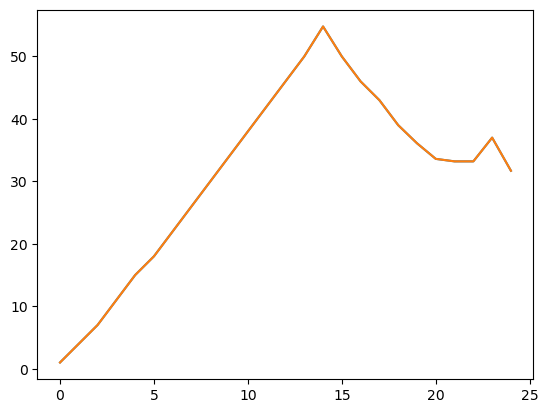

In [133]:
plt.plot(xmaxs_rr_cpu.mean(axis=1))
plt.plot(xmaxs_rr_gpu.mean(axis=1))

(None, <Axes: >, <matplotlib.image.AxesImage at 0x7f8190b9d9d0>)

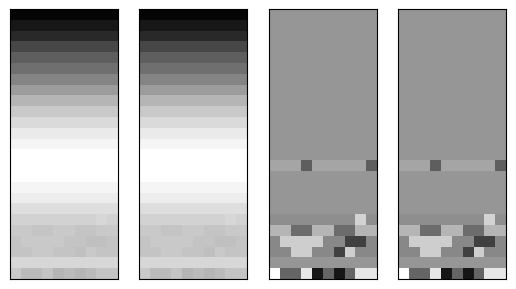

In [147]:
f,axs = plt.subplots(1,4)
vx0 = (0,50)
tfu.show_tif(xmaxs_rr_gpu,ax=axs[0], vminmax=vx0)
tfu.show_tif(xmaxs_rr_cpu,ax=axs[1], vminmax=vx0)
vx1 = (-2,2)
tfu.show_tif(xmaxs_rr_gpu-xmaxs_rr_gpu.mean(axis=1,keepdims=True),ax=axs[0+2], vminmax=vx1)
tfu.show_tif(xmaxs_rr_cpu-xmaxs_rr_cpu.mean(axis=1,keepdims=True),ax=axs[1+2], vminmax=vx1)

In [149]:
snrs = snrs.get()
errs = n.abs(xmaxs_nr_cpu - xmaxs_nr_gpu).mean(axis=0)
errs_t = n.abs(xmaxs_nr_cpu - xmaxs_nr_gpu)

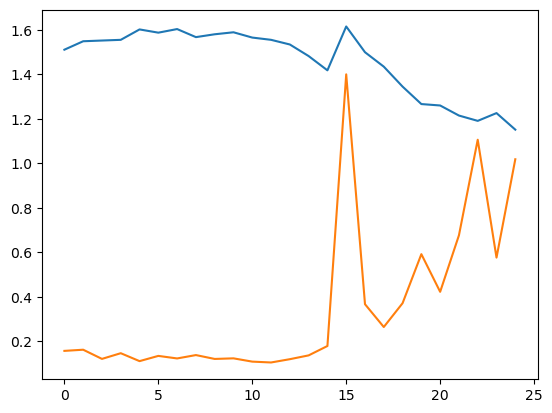

In [150]:
plt.plot(snrs.mean(axis=(0,2)))
plt.plot(errs_t.mean(axis=(0,2)))

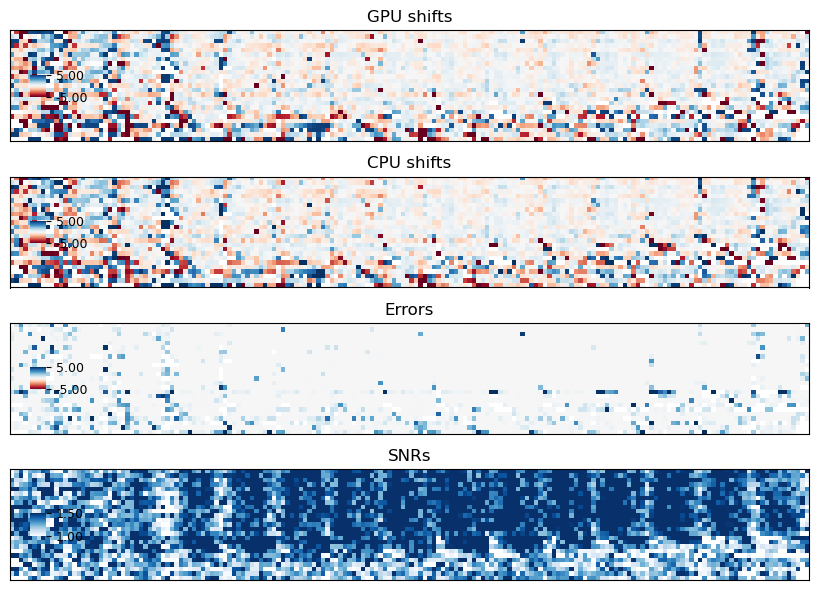

In [151]:
f,axs = plt.subplots(4,1, figsize=(16,6))
tidx = 5
snr_vis_thresh = 1.0
vx0 = (-5,5)
cmap='RdBu'
snr_mask = (snrs > snr_vis_thresh).astype(float)
tfu.show_tif(xmaxs_nr_gpu[tidx],ax=axs[0], vminmax=vx0, alpha=snr_mask[tidx], cmap=cmap, cbar=True)
axs[0].set_title("GPU shifts")
tfu.show_tif(xmaxs_nr_cpu[tidx],ax=axs[1], vminmax=vx0, alpha=snr_mask[tidx], cmap=cmap, cbar=True)
axs[1].set_title("CPU shifts")
tfu.show_tif(errs_t[tidx],ax=axs[2], vminmax=vx0, alpha=snr_mask[tidx], cmap=cmap, cbar=True)
axs[2].set_title("Errors")
tfu.show_tif(snrs[tidx],ax=axs[3], vminmax=(1.0, 1.5), alpha=snr_mask[tidx], cmap='Blues', cbar=True)
axs[3].set_title("SNRs")
plt.tight_layout()

In [137]:
snrs_sq = snrs.reshape(nt, nz, *nblocks)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f81f6bb6bb0>)

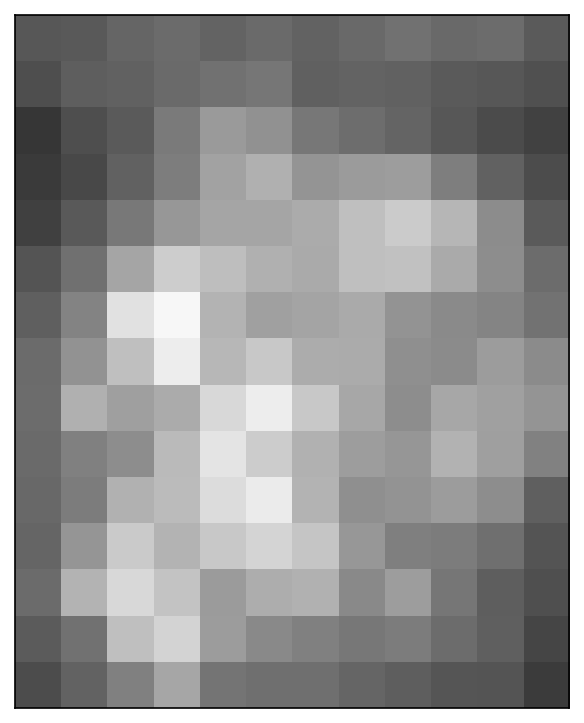

In [138]:
tfu.show_tif(snrs_sq.mean(axis=(0,1)), vminmax=(1.0,2.0))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f81bb1bd310>)

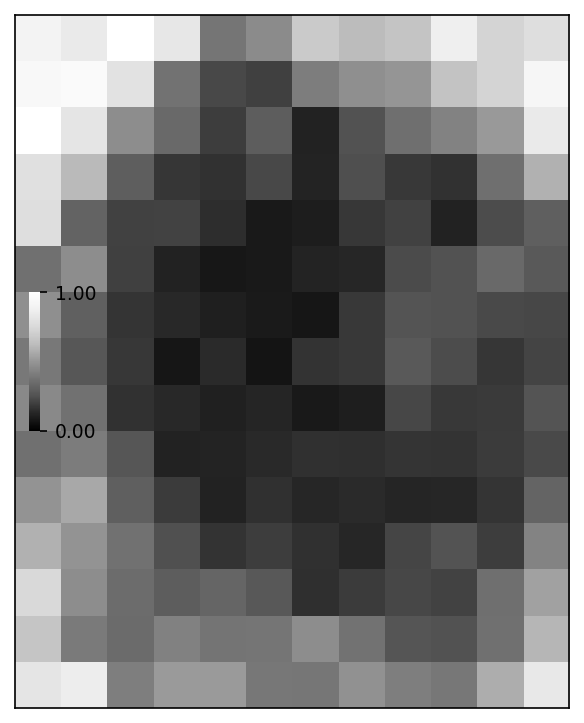

In [139]:
tfu.show_tif(errs.mean(axis=0).reshape(*nblocks), vminmax=(0,1.0),cbar=True)

In [11]:
import copy

%%time
shmem_mov,shmem_mov_params, mov = utils.create_shmem_from_arr(mov_pos, copy=True)
__ = iter_step.subtract_crosstalk(shmem_mov_params, crosstalk_coeff, planes = n.arange(*cz))
rigid_ops = []
for ops in all_ops:
    rigid_ops.append(copy.deepcopy(ops))
    rigid_ops[-1]['nonrigid']=False
__ = iter_step.register_mov(mov,refs_and_masks, rigid_ops)
mov_rr_cpu = mov.copy()
shmem_mov.close()
shmem_mov.unlink()